In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import folium
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# download/model a street network for some city then visualize it

place = ["Outremont", 'Le-Plateau-Mont_Royal','Rosemont-la-Petite-Patrie']
region_name = '+'.join(place)
Gb = ox.graph_from_place(place, network_type = 'bike')
Gd = ox.graph_from_place(place, network_type = 'drive')
#Gw =  ox.graph_from_place(place, network_type = 'walk')
#tags = {"leisure": 'park'}
#parks = ox.features_from_place(place, tags)
polygon = ox.geocode_to_gdf(place)

In [3]:
trips = pd.read_csv('Data/od18_extraqit_20250123/od18_extraqit_20250123.csv')
trips = trips[trips.potVelo == 1]

In [4]:
cols = ['ipere','feuillet','rang','xorig','yorig','xdest','ydest','mode','potVelo']
trips = trips[cols]
trips = gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.xorig, trips.yorig), crs='EPSG:32188')
trips = trips.rename(columns = {'geometry': 'orig'})
trips = trips.assign(dest = gpd.points_from_xy(trips.xdest, trips.ydest,crs='EPSG:32188'))
trips = trips.set_geometry('orig')
trips = trips.to_crs('EPSG:4326')
trips_within = gpd.sjoin(trips, polygon, how='inner', predicate='within')[list(trips.columns)+['name']]
trips_within = trips_within.set_geometry('dest')
trips_within = trips_within.to_crs('EPSG:4326')
trips_within = gpd.sjoin(trips_within, polygon, how='inner', predicate='within')[list(trips.columns)+['name_left','name_right']]

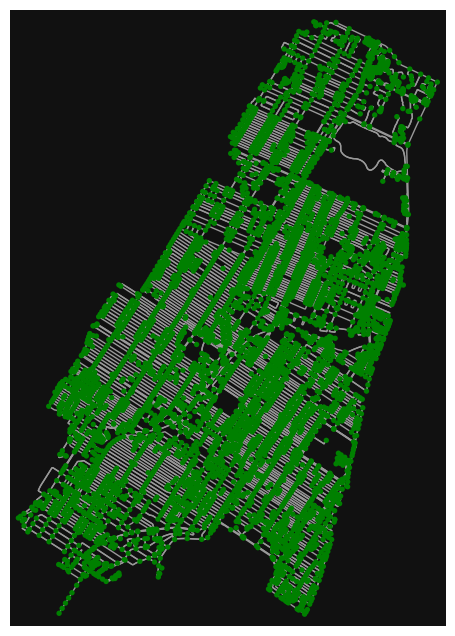

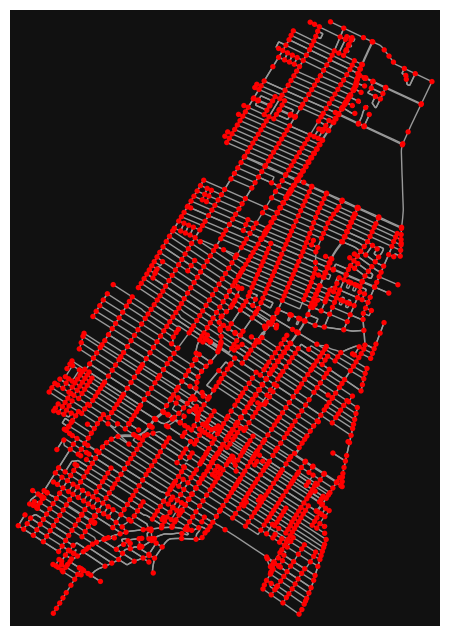

In [5]:
fig, ax = ox.plot_graph(Gb, node_color = 'green',save = False, filepath = 'Figures/reseaux/'+region_name+'_bike.png')
fig, ax = ox.plot_graph(Gd,node_color = 'red',save = False, filepath = 'Figures/reseaux/'+region_name+'_car.png')

In [6]:
Gd_proj = ox.project_graph(Gd)
Gd_clean = ox.consolidate_intersections(Gd_proj, rebuild_graph=True, tolerance=10, dead_ends=False)
nodes_d, edges_d = ox.graph_to_gdfs(Gd_clean)
edges_d = edges_d[edges_d.highway.isin(['residential','primary','secondary','tertiary','tertiary_link'])]
#edges_d = edges_d.reset_index()
#edges_d['dup'] = edges_d.apply(lambda row: tuple(sorted([row['u'], row['v']])), axis=1)
#t = edges_d[edges_d.duplicated(keep = False, subset = ['dup'])].sort_values(by = 'dup').head().explore()
#nodes_d.explore(m = t, color = 'black')
#edges_d = edges_d.drop_duplicates(subset='dup').drop(columns='dup')
#edges_d = edges_d.set_index(['u','v','key'])
#edges_d['reversed'].mask(edges_d['oneway'] == False, False, inplace=True)

In [7]:
# nodes_w, edges_w = ox.graph_to_gdfs(Gw)
# parks_buf =  gpd.GeoDataFrame(parks.buffer(10)).reset_index()
# parks_buf = parks_buf.rename(columns = {0:'geometry'})
# parks_buf = parks_buf.set_geometry('geometry').to_crs(4326)
# park_edges = gpd.sjoin(edges_w,parks_buf, how='inner', predicate='intersects')
# #park_nodes = gpd.sjoin(nodes_w, parks, how='inner', predicate='within')

In [8]:
# m = park_edges.explore()
# parks.buffer(10).explore(m = m,color = 'green')
# edges_d.explore(m = m,color = 'red')

In [9]:
#Gd_clean = ox.graph_from_gdfs(nodes_d,edges_d)

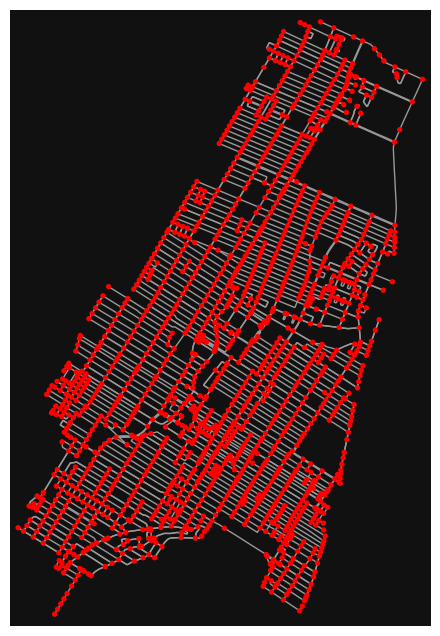

In [10]:
fig, ax = ox.plot_graph(Gd_clean,node_color = 'red',save = False, filepath = 'Figures/reseaux/'+region_name+'_car_clean.png')

In [11]:
Gb_proj = ox.project_graph(Gb)
Gb_clean = ox.consolidate_intersections(Gb_proj, rebuild_graph=True, tolerance=15, dead_ends=False)

In [12]:
nodes_b, edges_b = ox.graph_to_gdfs(Gb_clean)
edges_b.maxspeed = edges_b.maxspeed.fillna(0)
edges_b = edges_b[(edges_b.highway == 'cycleway')]# | ((edges_b.highway == 'residential') & (edges_b.maxspeed.astype(int)<=30))]
Gb_clean = ox.graph_from_gdfs(nodes_b,edges_b)

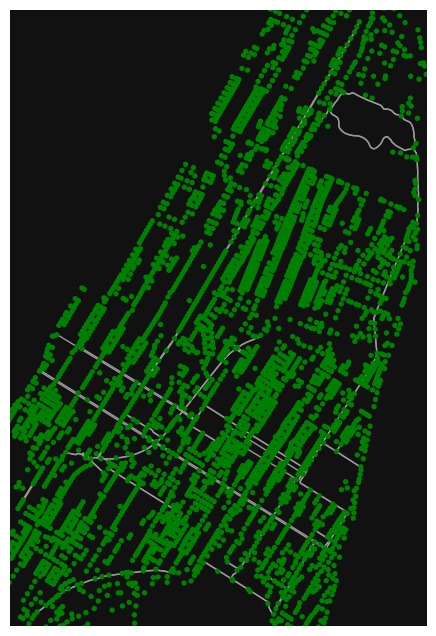

In [13]:
fig, ax = ox.plot_graph(Gb_clean, node_color = 'g',save = False, filepath = 'Figures/reseaux/'+region_name+'_bike_clean_R.png')

In [14]:
sample = trips_within.sample(1)
Gd_clean = ox.projection.project_graph(Gd_clean, to_crs = ('EPSG:4326'))
o_nodes,o_dists = ox.nearest_nodes(Gd_clean,sample.orig.x.values,sample.orig.y.values, return_dist=True)
d_nodes,d_dists = ox.nearest_nodes(Gd_clean,sample.dest.x.values,sample.dest.y.values, return_dist=True)

In [15]:
routes = ox.shortest_path(Gd_clean, o_nodes, d_nodes, weight="length")

In [17]:
routes_edges = []
unsolved = []
static = []

for i in tqdm(range(len(routes))):
    if routes[i]!=None:
        if len(routes[i])>1:
            edges = ox.routing.route_to_gdf(Gd_clean,routes[i])
            edges = edges.assign(route_number = i+1)
            routes_edges.append(edges)
    elif routes[i] == None:
        unsolved.append(i)
    else:
        static.append(routes[i])

routes_edges = pd.concat(routes_edges)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
sample = sample.set_geometry('orig')
map1 = sample.explore(color='blue', name='orig', size = 10)
sample = sample.set_geometry('dest')
map2 = sample.explore(color='red', name='dest', m=map1)
#map3 = polygon.explore(m = map1, name = 'polygon', color = 'green',fill_opacity = 0.1)
map4 = edges_b.explore(color='black', name='existing', m=map1)
map5 = edges_d.explore(color='black', name='potential', m=map1)
#map6 = nodes_d.loc[o_nodes].explore(color='yellow', name='o_close', m=map1)
#map7 = nodes_d.loc[d_nodes].explore(color='yellow', name='d_close', m=map1)
map8 = routes_edges.explore(color = 'yellow', name = 'route', m = map1)
folium.LayerControl().add_to(map1)
map1

In [259]:
routes_edges

osmid   highway  maxspeed                      name  \
u    v    key                                                             
1746 2259 0    1177407807  cycleway         0        Rue de Bellechasse   
2259 3592 1    1177407807  cycleway         0        Rue de Bellechasse   
3592 1651 0    1177407807  cycleway         0        Rue de Bellechasse   
1651 2245 0    1177407807  cycleway         0        Rue de Bellechasse   
2245 2258 0    1177407807  cycleway         0        Rue de Bellechasse   
...                   ...       ...       ...                       ...   
2140 2383 0    1150562444  cycleway         0        Rue de Bellechasse   
2383 3716 0    1150562444  cycleway         0        Rue de Bellechasse   
3716 1429 0    1150562444  cycleway         0        Rue de Bellechasse   
1429 1491 0    1210760236  cycleway         0  Avenue Christophe-Colomb   
1491 2529 1    1246863834  cycleway         0  Avenue Christophe-Colomb   

               oneway reversed      length  \
u    v    key                                
1746 2259 0      True    False  150.153199   
2259 3592 1      True    False   87.544394   
3592 1651 0      True    False   64.586810   
1651 2245 0      True    False   90.898519   
2245 2258 0      True    False  101.214950   
...               ...      ...         ...   
2140 2383 0      True    False   54.553588   
2383 3716 0      True    False   54.108313   
3716 1429 0      True    False   59.745930   
1429 1491 0      True    False  304.482145   
1491 2529 1      True    False  215.987148   

                                                        geometry   u_original  \
u    v    key                                                                   
1746 2259 0    LINESTRING (610859.24523 5045838.33316, 610854...  11013244478   
2259 3592 1    LINESTRING (610787.68308 5045717.00809, 610783...  11013244534   
3592 1651 0    LINESTRING (610747.1904 5045649.04439, 610746....  11020165771   
1651 2245 0    LINESTRING (610726.20615 5045611.46318, 610721...  11013244535   
2245 2258 0    LINESTRING (610685.52959 5045542.48249, 610680...  11013244472   
...                                                          ...          ...   
2140 2383 0    LINESTRING (609357.0342 5043372.51774, 609361....  10702950358   
2383 3716 0    LINESTRING (609381.08931 5043410.50459, 609384...  10702950357   
3716 1429 0    LINESTRING (609407.13262 5043448.95416, 609409...  10702950377   
1429 1491 0    LINESTRING (609434.18196 5043497.25523, 609433...  11217863366   
1491 2529 1    LINESTRING (609184.09826 5043649.39309, 609179...  11217863418   

                v_original  route_number width bridge  
u    v    key                                          
1746 2259 0    11013244534            24   NaN    NaN  
2259 3592 1    11020165771            24   NaN    NaN  
3592 1651 0    11013244535            24   NaN    NaN  
1651 2245 0    11013244472            24   NaN    NaN  
2245 2258 0    11013244538            24   NaN    NaN  
...                    ...           ...   ...    ...  
2140 2383 0    10702950357          2392   NaN    NaN  
2383 3716 0    10702950377          2392   NaN    NaN  
3716 1429 0    11217879141          2392   NaN    NaN  
1429 1491 0    11217863390          2392   NaN    NaN  
1491 2529 1    11217863427          2392   NaN    NaN  

[820 rows x 13 columns]

In [261]:
routes_edges.explore()